# NBA Game Summary Generator

### Fun project to try and generate NBA game summaries based on game previews only

- Generally following this guide to fine-tune GPT2 with a game preview & game summary dataset: 

https://colab.research.google.com/drive/1-rKrpWdBR6lliDbJGObkBHsZgk6t2Thz#scrollTo=8a8d8ded

- Using game previews and summaries from Rotowire
- Running analysis on Amazon SageMaker Studio Lab with available GPU resources

In [2]:
import sys
!{sys.executable} -m pip install numpy pandas seaborn torch transformers

  Using cached numpy-1.24.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached pandas-1.5.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.2 MB)
  Using cached seaborn-0.12.2-py3-none-any.whl (293 kB)
  Using cached torch-1.13.1-cp39-cp39-manylinux1_x86_64.whl (887.4 MB)
  Using cached transformers-4.26.0-py3-none-any.whl (6.3 MB)
     |████████████████████████████████| 499 kB 6.9 MB/s eta 0:00:01
  Using cached matplotlib-3.6.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.8 MB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached nvidia_cublas_cu11-11.10.3.66-py3-none-manylinux1_x86_64.whl (317.1 MB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached regex-2022.10.31-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (769 kB)
  Using

In [1]:
import pickle
import os
import time
import datetime

import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib as plt


import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

import transformers
from transformers import Trainer, TrainingArguments

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup


In [2]:
import pickle

with open("game_preview_summary.pkl", "rb") as file:
    game_details = pickle.load(file)
for i in range(len(game_details)):
    for j in range(len(game_details[i])):
        game_details[i][j] = game_details[i][j].replace('\t', ' ').replace('\n', ' ').replace('      ',' ')

/tmp/ipykernel_104/3076374727.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word_counts)


<AxesSubplot: ylabel='Density'>

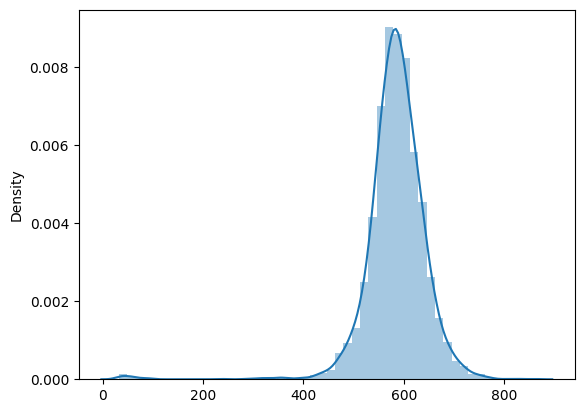

In [3]:
word_counts = []

for i in range(len(game_details)):
    for j in range(len(game_details[i])):
        words = game_details[i][j].split()
        word_counts.append(len(words))
        
sns.distplot(word_counts)

In [4]:
final_dataset = [item for sublist in game_details for item in sublist]
len(final_dataset)

4275

In [5]:
import transformers
from transformers import GPT2Tokenizer
from transformers import Trainer, TrainingArguments

class GPT2FineTuner:
    def __init__(self, dataset, model_name="gpt2"):
        self.tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        self.model = GPT2ForCausalLM.from_pretrained(model_name)
        self.dataset = dataset

    def fine_tune(self, num_epochs):
        training_args = TrainingArguments(
            output_dir='./results',          # output directory
            evaluation_strategy = "steps",  # Evaluation is done at the end of each training step
            logging_dir='./logs',            # directory for storing logs
            save_total_limit=1,              # save only the best model
            overwrite_output_dir=True,       # overwrite the output directory
            num_train_epochs=num_epochs      # number of training epochs
        )
        
        trainer = Trainer(
            model=self.model,               # the model to train
            args=training_args,             # training arguments, defined above
            train_dataset=self.dataset,      # training dataset
            eval_dataset=self.dataset,       # evaluation dataset
            tokenizer=self.tokenizer         # tokenizer to use
        )
        
        trainer.train()


In [6]:
batch_size = 4
class GPT2Dataset(Dataset):
    
    def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

        self.tokenizer = tokenizer
        self.input_ids = []
        self.attn_masks = []

        for txt in txt_list:

            encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

            self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attn_masks[idx] 

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


In [9]:
dataset = GPT2Dataset(final_dataset, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

3,420 training samples
  855 validation samples


In [10]:
# Create the DataLoaders for our training and validation datasets.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [11]:
import random

configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [12]:
epochs = 10
learning_rate = 3e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs
print(total_steps)

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

8550


In [ ]:
import time

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 10 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    855. Loss: 2.562645196914673.   Elapsed: 0:01:30.
0:  bipartisan
 to the House and Senate, respectively. ‣   

When it was year since the opening of the United State Elections, that the Republican Congress had been unable to eliminate a federal deficit, leading to a massive federal government deficit to come into the state at the expense of the state and its citizens. This was the result of a conspiracy that took advantage of the opportunity at the time, to bring about the downfall of the United State in the American Century and provide the Democrats with a strong advantage in the Democratic race. This was the final defeat of the United State at the end of November, when they defeated the United States in the American campaign by a total of 8.8 percent victory. The victory in the third quarter of August in a contest between the United States and the New York United States led to the opening of the United State elections, which were tied at 7-6. The United States de

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    855. Loss: 1.6634949445724487.   Elapsed: 0:03:02.
0:  increasingCeltas Airlines has announced that the (Aircraft) division in the United States is in receipt of an (AT& ) franchisee is performing well in their current eight-game season. The most recent record is the 10-5 mark, which is the second of their nine-game winning streak. The most recent record of that streak is a 116-121 loss, which is the second-most recent mark of that streak. In addition, the Chicago Bulls (20-19) have won seven of their last eight contests and have lost three of their last four contests, but they have won five in a row. The Bulls (20-19) are in action against the Indiana Pacers (20-19) on Thursday and must take care of business on Friday, as they face the Phoenix Suns (20


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    855. Loss: 2.0576529502868652.   Elapsed: 0:04:36.
0: dayS-39-9-7, 40 years ago.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    855. Loss: 1.6442192792892456.   Elapsed: 0:06:07.
0:  HangHouston Rockets at Toronto Raptors  November 4, 2020 at 08:30 PM The Toronto Raptors play host to the Houston Rockets at Amalie Arena on Saturday.  The Raptors have reached the second round of the west-19 NBA Playoffs, where they'll check into their first ever NBA All-Star berth. With their most recent success, they have won three in a row and are the first team to clinch the top seed in the NBA since the beginning of this season. That has them listing James Harden (knee), DeMar DeRozan (thumb) and DeAndre Jordan (hip). Those three players posted high points last season, as they are arguably the best player in the NBA and will keep going as long as this team wants to get as healthy as possible.  The Raptors have dropped three of their last five games, as they've been out-rebounded by the Clippers, 49-41, over the last month. In fact, that has dropped their most


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    855. Loss: 1.5400999784469604.   Elapsed: 0:07:41.
0:  foodsMemphis Grizzlies at Minnesota Timberwolves  October 29, 2021 at 07:00 PM The Memphis Grizzlies play host to the Minnesota Timberwolves at Fiserv Forum on Monday evening.   This marks the second game of a back-to-back for the Grizzlies (12-10), as they look to build on a two-game win streak. They are listing DeMarcus Cousins (COVID-19) as a game-time decision, while Karl-Anthony Towns (COVID-14) and T.J. McConnell (COVID-19) are listed as questionable due to ankle sprain. The Grizzlies are attempting to get more out of Tyus Jones (COVID-10), who has struggled to complete his role as a player, and that also leads to the possibility of him missing two or three games of action. The Grizzlies are listing Brandon Clarke (groin) as questionable.   Meanwhile, this marks the second game of a back-to-back for the Timberwolves


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    855. Loss: 1.5670859813690186.   Elapsed: 0:09:15.
0:  trail of in this way is a (14-1) with its main purpose being to make the most complicated offense to an offensive player who's the best player in this way. That's the name the guy that the New York Knicks have been calling the best player in the past year, making the top four of the six players in the first round for three years in a row. That's the real name that's the biggest thing for New York to be the best player in the world, with their second-best record and four-best record in that regard. They'll continue to make a push for the postseason, as the teams come up short. They just want to get the win


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    855. Loss: 1.1297035217285156.   Elapsed: 0:10:49.
0: intendNew Orleans Pelicans at Toronto Raptors  January 26, 2020 at 08:30 PM The Toronto Raptors play host to the New Orleans Pelicans at TD Garden on Thursday evening.   The Pelicans (26-34) have been solid at home, losing seven of their last eight games. They've won three of their last four before that, posting a 2-10 record through their first seven contests. Their most recent stumble came Wednesday night, when they fell to the Utah Jazz by a 103-99 score. The Raptors are shooting 47 percent from the field, including 22-of-36 from long range.   Meanwhile, this marks the second game of a back-to-back for the Pelicans, as they'll look to improve on their, 11-16, road record. Pascal Siakam (knee) will remain sidelined, while Jonas Valanciunas (knee) is listed as questionable for action.   This marks the second game of a back-to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    855. Loss: 1.4519175291061401.   Elapsed: 0:12:22.
0:  surroundPortland Trail Blazers at Miami Heat  January 11, 2022 at 08:00 PM The Portland Trail Blazers travel to Florida to face the Miami Heat at American Airlines Center on Friday night.  The Trail Blazers (17-6) just moved up to the second-worst road record in the NBA and while that might sound encouraging from a few eyes, some people still the team have to make do with three wins in a row.  Joel Embiid, who's expected to miss the next two months after suffering a calf injury and the Trail Blazers have had to deal with lots of injuries while finding some of their youngsters in need of help. In the end, though, they simply have to continue doing what they're doing and taking the next step into the postseason. The Trail Blazers are 6-6 at home this season, which is certainly an encouraging sign as this team has developed some nice chemistry since they've started with the winning ways this year.  The Heat (11-20

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    855. Loss: 1.395544409751892.   Elapsed: 0:01:32.
0:  reflexBoston Celtics at New Orleans Pelicans  January 19, 2020 at 07:30 PM The New Orleans Pelicans play host to the Boston Celtics at Smoothie King Center on Monday evening.   The Celtics (13-34) have seen their numbers improve with Chris Duarte playing well off the bench, and they now hold a three-game lead over the Pelicans (33-15) at home. What's also worth noting is that they enter the contest with more than three losses in their last four games. This has been the case the last two, as the Celtics have gone 6-11 on the road.   Meanwhile, the Pelicans (20-25) are coming off a loss against the Clippers on Thursday, and the Pelicans (25-19) have looked great from start to finish the season, entering this game winning six of their last eight games. That has become evident since they were on fire and have now gone 5-7 on the road. The game was supposed to be


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    855. Loss: 1.531270980834961.   Elapsed: 0:03:06.
0:  displayPhoenix Suns at Portland Trail Blazers  December 10, 2022 at 09:30 PM The Portland Trail Blazers play host to the Phoenix Suns at Moda Center on Wednesday evening.   This marks the second game of a back-to-back for the Trail Blazers (8-4), after they dropped a 119-106 decision to the Oklahoma City Thunder on Saturday night. Damian Lillard paced the Trail Blazers with 33 points, complementing them with eight assists, three rebounds and two steals. Anfernee Simons furnished 25 points, five assists, four rebounds and one steal. Bogdan Bogdanovic provided 17 points, seven boards, one assist and one steal.   The Trail Blazers will continue without Damian Lillard (finger) and Anfernee Simons (back) for Wednesday's game.   The Suns (4-5) check into Wednesday's contest on a two-game winning streak, as they hold a 2-0 mark over their last five games. They


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    855. Loss: 1.1752169132232666.   Elapsed: 0:04:40.
0:  pastorOrlando Magic at Golden State Warriors  December 4, 2022 at 08:30 PM The Golden State Warriors play host to the Orlando Magic at Chase Center on Thursday.  The Magic (23-34) have won their last five games, including their last four in a row, but their most recent success came Friday, when they toppled the Los Angeles Clippers by a 114-110 score. The Magic led 31-28 at halftime. Domantas Sabonis led the way with 23 points, complementing them with five assists, two rebounds, two steals and one block. Nikola Vucevic delivered 21 points, four assists, two rebounds and two blocks.  The Magic will continue without Jahlil Okafor (ankle), C.J. Miles (hamstring), Fred VanVleet (knee) and Franz Wagner (foot) for Thursday's game.  The Warriors (26-32) have won their last six games but have trailed their last two by double


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    855. Loss: 1.2001595497131348.   Elapsed: 0:06:14.
0:  illicitSan Antonio Spurs at Dallas Mavericks  January 5, 2020 at 09:00 PM The Dallas Mavericks play host to the San Antonio Spurs at American Airlines Center on Sunday evening.   The Spurs (29-25) have been one of the better teams in the NBA recently and as if that is not enough, they've won four of their last six outings against inferior competition. That gives them eight wins in their last eight contests and it has also allowed them to hold the top seed in the Western Conference once again. In fact, they currently sit in eighth place in the west and it has them playing in the midst of a tough stretch of play. The simple fact is, they are looking to keep rolling and add to their, 12-18, home record. If they can keep winning, that could be one of the best home records in the Western Conference and fans are hopeful that this is a club that will stick around when they're ready to move on. This is the second-best


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    855. Loss: 1.3182512521743774.   Elapsed: 0:07:48.
0:  LiberationGolden State Warriors at Atlanta Hawks  March 26, 2022 at 07:30 PM The Golden State Warriors take on the Atlanta Hawks at State Farm Arena on Saturday night.  The Warriors (18-19) are coming off a 107-106 win over the Utah Jazz on Tuesday, and they've just dropped two of their last four contests. After a slow start to the season, the Warriors were able to get past the Jazz by a 26-23 score on Wednesday, though they were only able to get a triple-double from Chris Paul and Draymond Green. The Warriors got their work in the defensive end, as they were held to 23 points, six rebounds, four blocks and one steal. Stephen Curry missed one of those free throws, and it's worth noting that Golden State did not force a turnover in the final seconds.   The Hawks (17-20) were supposed to bounce back from a loss in Utah on Tuesday, and they did. The Hawks did what they


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    855. Loss: 1.4157661199569702.   Elapsed: 0:09:22.
0:  NamSacramento Kings at Washington Wizards  May 8, 2021 at 07:00 PM The Washington Wizards play host to the Sacramento Kings at Capital One Arena on Wednesday evening.  The Wizards (16-23) have won seven of their last 10 games, including a season-opening win on Wednesday, as they will look to end a four-game slide in the form of two consecutive wins and build on their 6-14 home record. Bradley Beal leads the Wizards, averaging 25.9 points and 8.4 assists, over the last 10 games. Thomas Bryant averages 21.0 points, 7.7 rebounds, 2.6 assists and 1.7 steals, while Deni Avdija averages 18.9 points, 6.8 rebounds and 2.8 assists per game. Oshae Brissett averages 16.7 points, 11.8 rebounds and 1.6 assists, while Rui Hachimura is averaging 12.9 points, 6.6 rebounds and 1


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    855. Loss: 1.3490970134735107.   Elapsed: 0:10:56.
0: IONCleveland Cavaliers at Miami Heat  December 4, 2019 at 07:00 PM The Cleveland Cavaliers take on the Miami Heat at American Airlines Arena on Monday night.  The Cavaliers (32-17) come into Monday's game without a home win since they have dropped two of their last three contests. Their most recent stumble came against the Portland Trail Blazers, which toppled them by a 118-117 score on Friday night. Collin Sexton led the way for Cleveland with 33 points, adding four rebounds, three assists and two steals. Malik Monk delivered 28 points, complementing them with six rebounds, one assist, three blocks and one steal. Darius Garland contributed 16 points, four rebounds, one assist, four steals and one block. Larry Nance, Jr. compiled 11 points, six boards, four assists, two steals and one block.  The Cavaliers will continue without Tristan Thompson (knee) for Monday's game.  The Heat (18-39) are coming off


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    855. Loss: 1.2998098134994507.   Elapsed: 0:12:30.
0:  glimpseToronto Raptors at Toronto Raptors  March 17, 2021 at 07:30 PM The Toronto Raptors take on the Toronto Raptors at Scotiabank Arena on Monday night.  The Raptors (35-34) are coming off a 109-103 victory over the Denver Nuggets on Saturday. Pascal Siakam led the way for the Raptors with 34 points, supplementing them with five rebounds, three assists, two steals and one block. Fred VanVleet furnished 24 points, five assists, one rebound, three blocks and one steal. Marc Gasol generated a 23-point, 12-rebound double-double that included three assists and three steals. Gary Trent managed 20 points, 11 rebounds and four assists. OG Anunoby managed 17 points, seven rebounds, one assist and two steals. Kyle Lowry supplied 17 points, five assists, one rebound and three steals.  The Raptors will be without Pascal Siakam, Fred VanVleet, Patrick McCaw, Patrick Patterson,

  Average training loss: 1.37
  Training epo

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    855. Loss: 1.294389009475708.   Elapsed: 0:01:32.
0:  LaureMemphis Grizzlies at Sacramento Kings  February 23, 2021 at 10:00 PM The Sacramento Kings play host to the Memphis Grizzlies at Golden 1 Center on Wednesday.   The Grizzlies (22-14) have won just six of their last 11 games and seem to be trending in the wrong direction, losing seven of their last 10 games in total. They are 4-5 in their last 10 games, but they are now 1-5 on the road this season. They will do their part to get going, as they look to avoid a fifth straight loss in order to build some momentum. The most recent loss was an ugly one, as it was a home loss against the Atlanta Hawks. Ja Morant led the way for the Grizzlies, amassing 24 points, eight rebounds, five assists, two blocks and a steal. Dillon Brooks followed up with 18 points, seven rebounds, four assists and three steals, while Jonas Valanciunas tallied 16 points and nine rebounds. The Grizzlies


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    855. Loss: 1.092525601387024.   Elapsed: 0:03:06.
0: ismMinnesota Timberwolves at Portland Trail Blazers  October 24, 2021 at 03:00 PM The Portland Trail Blazers play host to the Minnesota Timberwolves at Moda Center on Friday evening.   This marks the second game of a back-to-back for the Trail Blazers (17-14), as they look to build on a, 15-6, home record. They will look to get back on track, as they face the fifth and final game of a home stand, where they have gone 1-0. They are shooting 37.9 percent from the field, which is seventh worst in the league, and they are holding opponents to an average of 109.1 points per game. Damian Lillard (knee) missed the last contest and remains questionable for action on Friday. Jusuf Nurkic leads the team with 26.5 points, 3.2 rebounds, 9.0 assists and 1.3 steals per game. C.J. McCollum is averaging 18.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    855. Loss: 1.3468722105026245.   Elapsed: 0:04:40.
0: ounSacramento Kings at Miami Heat  January 27, 2020 at 08:00 PM The Sacramento Kings take on the Miami Heat at FTX Arena on Thursday night in the opener.   The Kings (0-1) have been one of the most pleasant surprises at FedEx Forum this season, posting a 13-8 record over their last 14 games. They continue that winning streak following their big four-game road swing this season, and they'll check into Thursday's game having clinched two straight wins. De'Aaron Fox leads the team, averaging 24.5 points, 7.0 rebounds and 2.0 blocks per game. Buddy Hield averages 20.7 points, 5.4 rebounds, 5.4 assists and 1.3 steals, while Richaun Holmes averages 16.8 points, 9.9 rebounds and 1.3 blocks per game. The Kings average 113.9 points per game, but they give up an average of 116.3 points against.  


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    855. Loss: 1.170497179031372.   Elapsed: 0:06:14.
0:  electionMemphis Grizzlies at Detroit Pistons  January 6, 2022 at 08:00 PM The Memphis Grizzlies take on the Detroit Pistons at Little Caesars Arena on Wednesday night.  The Grizzlies (22-26) check into Wednesday's game on a two-game losing streak, as they've dropped seven of their last 10 games. Their most recent stumble came Sunday night, when they fell to the Indiana Pacers by a 115-106 score. Jonas Valanciunas paced the Grizzlies with 34 points, supplementing them with six assists, six rebounds and two steals. Brandon Clarke registered 24 points, three boards, three assists and one block. Desmond Bane supplied 23 points, six rebounds, one assist and one steal. Xavier Tillman generated a 14-point, 10-rebound double-double that also included one assist, two blocks and one steal. Jaren Jackson registered 12 points, seven rebounds, five assists, one steal and one block. Dillon Brooks and Santi Aldama generated


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    855. Loss: 1.1198256015777588.   Elapsed: 0:07:48.
0:  crazyAtlanta Hawks at Washington Wizards  March 11, 2022 at 07:00 PM The Washington Wizards play host to the Atlanta Hawks at Capital One Arena on Sunday evening.   This marks the second game of a back-to-back for the Wizards (2-3), as they are coming off a win over the Pelicans on Sunday evening. They had a chance to get back on track after one of the third quarters of their loss in that contest, however, where they outscored the visitors by 26 points in the middle of the fourth quarter to take a four-point advantage into the final period. They did not trail in the fourth, however, and remain secure in the fourth, where they face the fourth and final game of a home stand hoping to add to their, 1-4, road record. Bradley Beal (ankle) will remain sidelined through Sunday's action, while Deni Avdija (ankle) is listed as questionable for action. The Wizards will be


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    855. Loss: 1.1397720575332642.   Elapsed: 0:09:22.
0:  benchChicago Bulls at Indiana Pacers  January 3, 2022 at 08:00 PM The Chicago Bulls take on the Indiana Pacers at Gainbridge Fieldhouse on Thursday night.  The Bulls (28-25) have had some encouraging news thus far, with the best stretch of play of the season coming Wednesday night, when they overcame a late two-point deficit to snap a two-game skid. Their most recent time on the floor, however win marked their fourth straight loss, while they also snapped a three-game losing streak. Zach LaVine paced the Bulls with 24 points, complementing them with nine assists, three rebounds, two steals and one block. Thaddeus Young generated a 22-point, 12-rebound double-double that also included four assists and one steal. Tomas Satoransky compiled 19 points and three rebounds.  The Bulls will continue without Patrick Williams (wrist) for Thursday's game.  The Pacers (26-33) haven't had


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    855. Loss: 1.1279098987579346.   Elapsed: 0:10:55.
0:  incorporatedPortland Trail Blazers at Cleveland Cavaliers  December 9, 2019 at 07:00 PM The Portland Trail Blazers take on the Cleveland Cavaliers at Rocket Mortgage Fieldhouse on Saturday night.   The Trail Blazers (19-17) have been riding high off a five-game winning streak and an 11-5 mark in the last six contests overall, but they're still struggling right now. Portland has dropped seven of their last 10 games, including the last two contests at home. Their most recent stumble came against the Minnesota Timberwolves, which toppled them by a 115-111 score Saturday night. Damian Lillard led the Trail Blazers with 23 points, adding four rebounds, five assists, one steal and one block. Jusuf Nurkic supplied 18 points, five boards, two assists, two steals and two blocks. Anfernee Simons generated an 18-point, 11-rebound double-double that included three assists.  The Trail Blazers come into Saturday's game witho

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    855. Loss: 1.0442063808441162.   Elapsed: 0:12:29.
0: PeterOrlando Magic at Los Angeles Clippers  August 13, 2021 at 10:00 PM The Los Angeles Clippers play host to the Orlando Magic at Staples Center on Sunday.   The Magic (32-18) come into this matchup losing nine of their last 11 games. This stretch has been going on for years and it's really no surprise to see this club play so poorly. Many people consider it a broken record but the direct correlation is that Cole Anthony, Aaron Gordon, Wendell Carter, Markelle Fultz, Nikola Vucevic, and Jonathan Isaac have all been suspended. All of those guys have shown flashes of brilliance and it feels like they can play better without those youngsters. Many people were worried they could be facing a rebuilding team but it's been way too early to get excited about what they look like.   The Clippers (22-13) had one of their worst performances of the season on Monday, blowing out the Oklahoma City Thunder. They played better 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    855. Loss: 1.1019972562789917.   Elapsed: 0:01:28.
0: uringNew Orleans Pelicans at Houston Rockets  February 1, 2020 at 07:00 PM The New Orleans Pelicans travel to Texas to face the Houston Rockets at Toyota Center on Thursday.   The Pelicans (23-27) suffered a devastating road loss on Saturday against the New Orleans Pelicans, handing the Memphis Grizzlies a 120-98 defeat. Jonas Valanciunas led the way for the Pelicans with 24 points, complementing them with five rebounds, five assists and one steal. Jose Alvarado provided a 21-point, 11-rebound double-double that also included two assists, four blocks and one steal. Brandon Ingram netted 18 points, three rebounds, one assist and one steal. Zion Williamson registered 15 points, four rebounds and four assists. Herbert Jones delivered 13 points, two rebounds, two assists and one steal. New Orleans has dropped seven of its last 10 games.   The Rockets (38-20) are not a lock to play in Thursday's game as they have


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    855. Loss: 0.9248749017715454.   Elapsed: 0:02:58.
0:  reproductiveBoston Celtics at Utah Jazz  November 8, 2020 at 09:00 PM The Boston Celtics take on the Utah Jazz at Vivint Smart Home Arena on Wednesday night.  The Celtics (22-18) come into Wednesday's game in dire straits, as they've dropped five consecutive games. Their most recent stumble came Friday night, when they fell to the New York Knicks by a 124-103 score. Jayson Tatum led the Celtics with 27 points, complementing them with nine rebounds, five assists and one steal. Jaylen Brown supplied 24 points, five rebounds, one assist, three steals and one block. Marcus Smart managed 18 points, six rebounds, seven assists and one steal. Derrick White supplied 12 points, two boards and one block.   The Celtics will likely list Kemba Walker (knee), Jaylen Brown (knee) and Robert Williams III (concussion) as out for Wednesday's game.  The Jazz (21-19) come into Wednesday


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    855. Loss: 1.08805251121521.   Elapsed: 0:04:27.
0:  zonePhoenix Suns at Charlotte Hornets  January 8, 2023 at 07:00 PM The Phoenix Suns travel to South Beach to face the Charlotte Hornets at Spectrum Center on Thursday.   The Suns (24-12) just picked up a loss last Friday. That snapped a two-game winning streak, with Phoenix falling all the way to.500. That's a lot of volatility this club has had to deal with all season long, and it's left this roster extremely thin. While DeAndre Ayton is expected to return in about a month, this team needs to do a better job at the ball-handler positions, holding guys like Devin Booker, Ricky Rubio and Landry Shamet to 42 percent shooting. That's an unacceptable number of shots taken from the field and is simply an excuse for the poor play on this roster.   The Hornets (24-13) enter this matchup in the midst of a five-game losing streak. This was a club that won eight of their


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    855. Loss: 1.251861333847046.   Elapsed: 0:05:56.
0:  commitsToronto Raptors at Brooklyn Nets  February 6, 2022 at 07:30 PM The Toronto Raptors take on the Brooklyn Nets at Barclays Center on Friday night.  The Raptors (14-25) have been the more frequent visitors to the expense-store than their opponents, but they've opened up their Eastern Conference title to a 3-3 record overall. Their most recent time on the floor did result in one of those wins, however, as they toppled the San Antonio Spurs by a 112-97 score Wednesday night. Fred VanVleet led the Raptors with 19 points, complementing them with two rebounds, four assists, two steals and one block. OG Anunoby poured in 15 points. OG Anunoby furnished 12 points, two assists, two rebounds and one steal. Scottie Barnes managed 10 points, four assists, one rebound and one steal. Scottie's two steals came at the foul line, and no other Toronto player scored in double digits.   The Raptors will


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    855. Loss: 1.0982688665390015.   Elapsed: 0:07:25.
0:  ironyMinnesota Timberwolves at Houston Rockets  January 27, 2020 at 08:30 PM The Minnesota Timberwolves take on the Houston Rockets at Toyota Center on Friday night.  The Timberwolves (28-25) continue to battle inconsistency to determine the best team in the Eastern Conference, but they'll come into Friday's contest looking to end a four-game slide and add to their, 14-11, home record. Malik Beasley led the Timberwolves with 32 points, adding five rebounds, five assists and one steal. Karl-Anthony Towns registered 22 points, five assists, four rebounds and one steal. Naz Reid delivered 15 points, five rebounds, one assist, two blocks and one steal. Anthony Edwards contributed 14 points, six boards, four assists and one steal.   The Timberwolves will continue without Jake Layman (knee) and Jarred Vanderbilt (hamstring) for Friday's game. Derrick Favors (back) will likely be listed as questionable. Taurean Prince

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    855. Loss: 1.0289695262908936.   Elapsed: 0:08:55.
0:  SahPhiladelphia 76ers at Memphis Grizzlies  December 17, 2022 at 08:00 PM The Memphis Grizzlies play host to the Philadelphia 76ers at FedEx Forum on Thursday evening.   This marks the fourth game of a six-game home stand for the Grizzlies (18-22), where they have gone, 1-2, so far, with losses in Charlotte and Minnesota, before their recent win over the Pistons. The Grizzlies will look to build off a win in Charlotte, as they look to contribute to their 11th home win of the season. Ja Morant leads the Grizzlies in scoring and shooting, averaging 20.1 points, 5.5 rebounds, 2.3 assists and 1.3 steals per game. Dillon Brooks averages 16.7 points, 5.8 rebounds and 4.9 assists, while Jonas Valanciunas averages 10.9 points, 3.5 rebounds and 3.9 assists per game. The Grizzlies average 112.7 points per game and are giving up


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    855. Loss: 0.972204864025116.   Elapsed: 0:10:27.
0:  BryanWashington Wizards at Sacramento Kings  February 2, 2021 at 10:00 PM The Sacramento Kings play host to the Washington Wizards at Golden 1 Center on Tuesday.   The Wizards (5-11) pulled off one of their best wins of the season on Sunday, handing the Charlotte Hornets their first loss of the season. It wasn't easy to understand exactly who was playing in that game, though, with Bradley Beal, Russell Westbrook, Rui Hachimura and Thomas Bryant all playing at the five. That's not something you would expect either, with Beal playing 26 minutes per game and Westbrook providing 25 points and 11 rebounds. Westbrook has been an issue all season and it's becoming clear that he won't be around for the foreseeable future. Having Thomas Bryant back in the lineup and then Westbrook being reinserted into the starting lineup has opened up some serious discussion, and it's hard to imagine things getting much better with all 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    855. Loss: 1.2110494375228882.   Elapsed: 0:12:01.
0:  spiritsDenver Nuggets at Portland Trail Blazers  January 20, 2022 at 09:00 PM The Portland Trail Blazers play host to the Denver Nuggets at Moda Center on Wednesday.   The Nuggets (12-9) have been a pleasant surprise in the Western Conference, but they continue to struggle to attain a.500 record. They had a strong performance in Dallas in the opener, but they can't compete with anyone in that bubble. The good news is that Nikola Jokic returned from injury in the most recent win over the Washington Wizards on Tuesday. He's not walking through that door any time soon either, with Jamal Murray dropping 14 points on 7-of-13 shooting, in that defeat. That emphasizes just how hard they've been to figure out, with Denver looking like one of the best teams in the NBA if Jokic continues to miss games. That emphasizes just how valuable he is, averaging 14.5 points, 4.6 assists, 2.4 rebounds and 1.

  Average training los

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    855. Loss: 1.1769099235534668.   Elapsed: 0:01:33.
0:  seesUtah Jazz at Charlotte Hornets  November 26, 2019 at 07:00 PM The Utah Jazz take on the Charlotte Hornets at Spectrum Center on Tuesday night.  The Jazz (17-13) have been one of the most surprising teams in the Western Conference this season, rattling off seven consecutive victories. Their most recent success came Saturday afternoon, when they toppled the Atlanta Hawks by a 111-103 score. Bojan Bogdanovic and Jordan Clarkson led the Jazz with 23 points apiece, with Bogdanovic also pulling down 10 rebounds and Clarkson recording five blocks. Rudy Gobert had a 19-point, 10-rebound double-double that also included two assists. Gobert turned in 10 points, eight assists, three rebounds and two steals. Mike Conley registered 14 points, nine assists and one rebound.  The Jazz will remain without Mike Conley (ankle) and Kelly Olynyk (knee) for Tuesday's game.  The Hornets (11-13)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    855. Loss: 1.07761549949646.   Elapsed: 0:03:07.
0:  hungryLos Angeles Lakers at Charlotte Hornets  March 29, 2021 at 07:00 PM The Charlotte Hornets will host the Los Angeles Lakers at Spectrum Center on Friday night.  The Hornets (21-23) are coming off a 103-90 win over the Milwaukee Bucks on Wednesday and that win snapped a two-game winning run for Charlotte. Jalen McDaniels led the Hornets with 27 points, three rebounds and four assists, while Terry Rozier produced 26 points, seven assists and six rebounds. Kelly Oubre Jr. had 15 points, six rebounds and three steals, and Miles Bridges chipped in 13 points, five assists and six boards. The Hornets are 10-14 when playing at home this season and enter this game having won their last seven contests.  The Lakers (22-22) are coming off a loss against the Minnesota Timberwolves on Wednesday and that defeat snapped a seven-game winning streak for them. LeBron James, who continues to impress on both ends of the court,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    855. Loss: 1.1417253017425537.   Elapsed: 0:04:41.
0:  PTNew York Knicks at Toronto Raptors  December 26, 2020 at 07:30 PM The New York Knicks take on the Toronto Raptors at Scotiabank Arena on Thursday night in Game 4 of the Eastern Conference Finals. The Raptors (0-1) opened the series on the road looking to extend a modest two-game winning streak in their season-opening Game 3 victory, and they got off to an encouraging start in that regard by topping the Suns by a 119-111 score. Luka Doncic then paced the Knicks with 37 points, complementing them with nine assists and seven rebounds. R.J. Barrett followed with 24 points, adding five rebounds, four assists and one steal. Julius Randle generated a 15-point, 10-rebound double-double that included four assists, one steal and one block. Mitchell Robinson poured in 12 points, while Reggie Bullock and Immanuel Quickley generated matching 10-point tallies while dishing out four and three assists,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    855. Loss: 1.1555094718933105.   Elapsed: 0:06:15.
0: üLos Angeles Lakers at Charlotte Hornets  December 10, 2022 at 07:00 PM The Charlotte Hornets play host to the Los Angeles Lakers at Spectrum Center on Tuesday evening.   The Hornets (14-15) have dropped two in a row, including their last two in a row. They look to bounce back as they take on the Suns in Phoenix on Saturday. Terry Rozier (knee) missed the last contest and remains questionable for action on Tuesday. Devonte' Graham (leg) missed the last contest and remains questionable for action on Tuesday.   The Lakers (11-15) have dropped two in a row, including their last three in a row. They hope to bounce back as they kick off a four-game home stand with a chance to build on their 7-2 home record. Russell Westbrook leads the team, averaging 26.9 points, 9.1 rebounds and 5.0 assists per game. Anthony Davis averages 23.5 points, 8.3 rebounds


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    855. Loss: 1.0468502044677734.   Elapsed: 0:07:48.
0: ruceCharlotte Hornets at Memphis Grizzlies  December 17, 2022 at 08:00 PM The Memphis Grizzlies play host to the Charlotte Hornets at FedEx Forum on Sunday.   The Hornets (17-19) have the exact same record as the Grizzlies (13-13), but a recent win over the Nuggets had them above.500. That's the team that we saw before that loss but it's easy to see why when looking at the stat sheet. The one thing missing is their frontcourt. Luka Doncic has missed most of the season with a back issue, and that's going to make it hard for this team to compete. The absence of LaMelo Ball obviously has them out of contention, but the shooting is. This is the team that we saw at full health when Terry Rozier went down, with Gordon Hayward returning and Davis Bertans starting at point guard. The issue has to do with Gordon's shooting, and that's way too much for a roster like this


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    855. Loss: 1.1008409261703491.   Elapsed: 0:09:22.
0:  derivativesMemphis Grizzlies at San Antonio Spurs  December 8, 2021 at 08:00 PM The San Antonio Spurs play host to the Memphis Grizzlies at AT&T Center on Wednesday evening.   The Spurs (2-0) have won six in a row and will look to keep rolling to build on their, 2-1, home record. Dejounte Murray leads the team, averaging 17.1 points, 9.2 rebounds, 3.3 assists and 1.6 steals per game. Jakob Poeltl is averaging 17.7 points, 10.2 rebounds and 2.7 assists, while Devin Vassell averages 11.4 points, 4.5 rebounds and 4.8 assists per game. Keldon Johnson (ankle), Keita Bates-Diop (knee) and Keita Bates-Diop (wrist) are listed as questionable, while Doug McDermott (finger) and Jakob Poeltl (personal) remain out. The Spurs


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    855. Loss: 1.2357378005981445.   Elapsed: 0:10:56.
0: Indiana Pacers at Minnesota Timberwolves  December 4, 2022 at 08:00 PM The Indiana Pacers take on the Minnesota Timberwolves at Target Center on Sunday night.  The Pacers (15-13) have dealt with some modest adversity in the immediate wake of a pair of COVID-19 absences they suffered against the Boston Celtics, and they'll likely be looking to put a positive in the right direction with a Monday night win over the Denver Nuggets. Their most recent success came at the expense of the Philadelphia 76ers, which they toppled by a 117-112 score Monday night. Domantas Sabonis led the Pacers with a 34-point, 19-rebound double-double that also included three assists and one steal. Caris LeVert generated a 22-point, 13-assist double-double that also included two steals and two blocks. Chris Duarte poured in 21 points, while Jeremy Lamb contributed 10 points, six rebounds and four assists. Myles Turner generated a 10-


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    855. Loss: 1.0705127716064453.   Elapsed: 0:12:30.
0:  rememberingCharlotte Hornets at Toronto Raptors  October 25, 2021 at 07:30 PM The Charlotte Hornets take on the Toronto Raptors at Scotiabank Arena on Saturday night.  The Hornets (0-1) have opened the season in strong fashion in the absence of first overall pick PJ Washington, and they'll enter Saturday's contest having won five of their last seven contests overall. Their most recent success came at the expense of the Denver Nuggets, which they edged by a 97-87 score Tuesday night. Devonte' Graham paced the Hornets with 30 points, complementing them with eight rebounds, one assist and one block. Terry Rozier furnished 28 points, four boards and four assists. P.J. Washington posted 23 points, eight boards, four assists and one steal. Jalen McDaniels and P.J. Washington generated matching 12-point tallies, with McDaniels also recording four assists and three rebounds.  The Hornets will list Malik Monk (ankle) an

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    855. Loss: 1.0665719509124756.   Elapsed: 0:01:32.
0:  SourcesCharlotte Hornets at Toronto Raptors  February 2, 2021 at 07:30 PM The Charlotte Hornets take on the Toronto Raptors at Scotiabank Arena on Thursday night.  The Hornets (25-37) continue to manage a difficult schedule, although they'll enter Thursday's game having dropped nine of their last 11 contests. Their most recent stumble came against the Houston Rockets, which toppled them by a 119-107 score Monday night. Devonte' Graham led the Hornets with 27 points, adding nine assists, six rebounds and two steals. Miles Bridges generated a 17-point, 14-rebound double-double that also included three assists, two blocks and one steal. Gordon Hayward furnished 16 points, four assists, two rebounds, two steals and one block. Jalen McDaniels registered 14 points, five boards, one assist and one steal.  The Hornets will list LaMelo Ball (knee), P.J. Washington (foot), Gordon Hayward (personal), Malik Monk


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    855. Loss: 1.1895025968551636.   Elapsed: 0:03:01.
0: emsNew Orleans Pelicans at Houston Rockets  January 16, 2023 at 08:00 PM The Houston Rockets play host to the New Orleans Pelicans at Toyota Center on Thursday.   The Pelicans (24-36) have had an ugly season, but they enter this matchup winning four of their last six games. This club has the best record in the NBA, but it was actually an uphill battle before a.500 run last year. New Orleans fans can't get enough of the play from Zion Williamson and Brandon Ingram, and those two guys carried them during last year's MVP run. Many people thought this could be an issue because Lonzo Ball broke his hand, and it's sad to see him drop out of the MVP discussions. Players like Jrue Holiday, Jonas Valanciunas and CJ McCollum have been fantastic, but we haven't even discussed Zion and Brandon Ingram themselves. They need Brandon Ingram, though, because this club looks like a shell of itself in his absence.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    855. Loss: 1.1478281021118164.   Elapsed: 0:04:31.
0: tzMemphis Grizzlies at Houston Rockets  March 26, 2022 at 08:00 PM The Houston Rockets will host the Memphis Grizzlies at Toyota Center on Tuesday night.  The Rockets (5-25) are coming off a 121-112 overtime win over the Oklahoma City Thunder on Saturday. Christian Wood led the Rockets with a game-high 27 points on 8-of-16 shooting, in 30 minutes. Kevin Porter added 20 points, while Jalen Green added 20 points and 10 rebounds. Alperen Sengun added 17 points, seven rebounds, six assists and a steal. Jalen Green added 10 points and four assists. Houston shot 42.0 percent from the field, including 10-of-28 from deep. Houston has gone 2-7 at home this season and has gone 1-3 in their last four.  Alperen Sengun (personal) is a game-time decision for Tuesday's game, while Kevin Porter (groin) is out.  The


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    855. Loss: 1.2309987545013428.   Elapsed: 0:06:00.
0: maticBrooklyn Nets at Orlando Magic  August 8, 2020 at 06:00 PM The Orlando Magic play host to the Brooklyn Nets in Orlando on Friday evening.   This marks the first game of a five-game home stand for the Magic (6-15), which they began with a win in Milwaukee on Friday. The Magic will look to add to their, 2-6, home record, as they return home from a one-game slide, where they lost four in a row. Evan Fournier continues his strong play, averaging 19.1 points, 5.9 rebounds, 5.4 assists, 1.4 steals and 1.4 blocks, over the last 10 games, and is shooting 43 percent from the field. Nikola Vucevic continues to be strong and is averaging 18.5 points on 48 percent shooting, including 50 percent from long range, over the last 10 games. Evan Fournier continues to play well, averaging 14.6 points on 48 percent


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    855. Loss: 1.0645641088485718.   Elapsed: 0:07:29.
0:  syndPortland Trail Blazers at Miami Heat  November 22, 2021 at 07:30 PM The Portland Trail Blazers take on the Miami Heat at FTX Arena on Monday night.  The Trail Blazers (12-11) continue to struggle on a consistent basis, but they'll check into Monday's contest having forged a 4-2 record over their last seven games. Their most recent time on the floor did result in one of those victories, as Portland toppled the San Antonio Spurs by a 109-98 score Wednesday night. Damian Lillard led the way with 41 points, complementing them with six rebounds, three assists and two steals. C.J. McCollum followed with 18 points, adding four rebounds, four assists and one steal. Carmelo Anthony supplied 12 points, four rebounds, one assist and three steals.   The Trail Blazers are slated to remain without Mario Hezonja (thumb) and Gary Payton (toe) on Monday. Norman Powell (ankle) will be listed


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    855. Loss: 1.078326940536499.   Elapsed: 0:08:59.
0:  gamDetroit Pistons at Chicago Bulls  March 30, 2022 at 08:00 PM The Chicago Bulls will host the Detroit Pistons at United Center on Wednesday night.  The Bulls (35-31) have been quite shorthanded this season but are coming off a comfortable win over the Brooklyn Nets on Monday. DeMar DeRozan led the Bulls with 31 points, complementing them with six assists, five rebounds and one steal. Zach LaVine managed 26 points, five assists and five rebounds. Coby White supplied 23 points, five assists, one rebound and three steals. Nikola Vucevic managed 14 points, six rebounds and six assists. DeRozan and Vucevic produced matching 10-point efforts, with Vucevic also pulling down five rebounds.  The Pistons (34-31) are coming off a loss against the Utah Jazz on Monday. Cade Cunningham (knee) and Jerami Grant (personal) are both questionable for action. Marvin Bagley (foot


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    855. Loss: 1.1380175352096558.   Elapsed: 0:10:31.
 This marks the fourth game of a six-game home stand for the Nuggets (9-7), where they have gone 0-1, so far. The Nuggets are 7-2 at home, where they have been strong at home, including an impressive win in their most recent contest. Nikola Jokic leads the Nuggets, averaging 22.7 points, 11.0 rebounds, 8.6 assists and 1.3 steals per game. Aaron Gordon is averaging 16.8 points, 8.0 rebounds, 4.0 assists and 1.0 steals, while Bruce Brown is averaging 15.5 points, 3.2 rebounds, 3.6 assists and 1.2 steals per game. The Nuggets are averaging 110.0 points per game, and they are holding opponents to an average of 110.6 points


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    855. Loss: 1.1361953020095825.   Elapsed: 0:12:05.
0: azaDenver Nuggets at Golden State Warriors  December 13, 2021 at 08:30 PM The Golden State Warriors play host to the Denver Nuggets at Chase Center on Monday.   The Nuggets (1-1) got off to a bad start but have been unbeatable since then. They have one of the most talented rosters in the NBA with Nikola Jokic, Aaron Gordon, Facundo Campazzo and Monte Morris all stepping up for this team. The last three starters for this team have all averaged at least 25 points per game, which would make it tough to see them out of the gate. The next step is to get Gary Harris back in the fold. The former Duke point guard has been out since last week and would be a welcomed sight to the team.   The Warriors (1-1) pulled off one of the most impressive wins of the season on Sunday but lost to the Denver Nuggets. They actually had a game decided by five points or fewer, giving them a four

  Average training loss: 1.05
  Training e

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    855. Loss: 0.9682643413543701.   Elapsed: 0:01:33.
0:  membraneMilwaukee Bucks at Golden State Warriors  November 24, 2022 at 10:00 PM The Golden State Warriors play host to the Milwaukee Bucks at Chase Center on Wednesday.   The Bucks (1-0) have dominated this series over recent years, but they enter this matchup in the midst of a five-game losing streak. They lost three of their last four, but look for the road to be even more challenging. In any case, the Bucks got off to a good start, finishing on an 11-1 run to prevail in Phoenix on Monday. Giannis Antetokounmpo actually finished that game with 48 points and 13 rebounds while adding 10 assists, and Jrue Holiday finished with 17 points and seven assists. If the Bucks were to pull the upset here, it could be the end of this lengthy winning streak. The star of that show in this game is Khris Middleton, who collected 29 points, six rebounds and eight assists. He actually only played 40 minutes


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    855. Loss: 0.9181699156761169.   Elapsed: 0:03:04.
0: ijingDenver Nuggets at Oklahoma City Thunder  March 27, 2022 at 08:00 PM The Oklahoma City Thunder play host to the Denver Nuggets at Chesapeake Energy Arena on Saturday.   The Nuggets (24-26) have dropped seven of their last 10 games, including their last three in a row. This marks the second game of a four-game home stand for the Nuggets, as they look to snap a five-game slide. The Nuggets average 108.0 points per game, and they are holding opponents to an average of 107.5 points per game. However, they are giving up an average of 11.9 turnovers per game, which is third most in the league. Nikola Jokic has been playing great lately, averaging 19.4 points, 8.9 rebounds, 8.2 assists, 1.5 blocks and 1.0 steals per game. Jeff Green is averaging 15.3 points, 4.5 rebounds, 1.1 assists and 1.3 steals,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    855. Loss: 0.7927374839782715.   Elapsed: 0:04:34.
0:  castChicago Bulls at Atlanta Hawks  February 28, 2022 at 07:30 PM The Chicago Bulls take on the Atlanta Hawks at State Farm Arena on Thursday night.  The Bulls (20-32) continue to sport an unsightly record, but they'll check into Thursday's game having won three of the last four. Their most recent success came at the expense of the Oklahoma City Thunder, which they edged by a 102-89 score Monday night. Zach LaVine led the way with a 20-point, 11-assist, 10-rebound triple-double that included two steals. Thaddeus Young delivered 18 points, three assists and one rebound. Garrett Temple supplied 14 points, seven boards, one assist and one steal. Coby White managed 11 points, four boards, two assists and one block. Lauri Markkanen and Wendell Carter, Jr. pitched in matching nine-point tallies, with Markkanen also recording six rebounds and eight assists. 


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    855. Loss: 0.9774730205535889.   Elapsed: 0:06:04.
0:  purchPortland Trail Blazers at Indiana Pacers  January 27, 2021 at 07:00 PM The Indiana Pacers will host the Portland Trail Blazers at Gainbridge Fieldhouse on Saturday evening.  The Pacers (6-8) are coming off a loss against the Hawks on Wednesday, and that means they need to get back on track after losing their previous four games. Tyrese Haliburton led the Pacers with 22 points, three rebounds and four assists, in 42 minutes. Bennedict Mathurin followed up with 16 points, six rebounds and a steal, while Myles Turner added 13 points and eight rebounds. The Pacers shot 43 percent from the field, including 5-of-24 from long range. Indiana shot 47.1 percent from the field, including 18-of-43 from deep.  Myles Turner (thumb) and Jalen Smith (hamstring) are both game-time calls for Saturday’s game, while Isaiah Jackson (knee) is out.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    855. Loss: 0.9337000846862793.   Elapsed: 0:07:36.
0:  shouldersMinnesota Timberwolves at Atlanta Hawks  January 7, 2022 at 07:30 PM The Minnesota Timberwolves take on the Atlanta Hawks at State Farm Arena on Wednesday night.  The Timberwolves (6-13) had recently made some notable strides with their defense of the franchise by a solid 3-2 record, but they'll enter Wednesday's game having dropped three of their past four games. Their most recent stumble came Friday night, when they fell to the Memphis Grizzlies by a 110-103 score. Malik Beasley led the way with 19 points, adding seven rebounds, one assist and two blocks. Andrew Wiggins produced 17 points, four boards and four assists. Robert Covington totaled 16 points, six rebounds, three assists, one steal and one block. Robert Covington matched Wiggins' scoring total and added four rebounds, two assists and two steals.  The Timberwolves will list Karl-Anthony Towns (ankle) and Jaylen Nowell (leg) as questionable 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    855. Loss: 1.0571739673614502.   Elapsed: 0:09:10.
0:  builtAtlanta Hawks at San Antonio Spurs  December 9, 2021 at 08:00 PM The San Antonio Spurs play host to the Atlanta Hawks at AT&T Center on Saturday evening.   This marks the second game of a back-to-back for the Spurs (4-1), as they are coming off an impressive win in Toronto on Friday night. The Spurs led by eight, after one quarter and carried a 22-point lead into halftime. They came out strong in the third but could only trim it to a three-point game, heading into the final frame. The hosts kept it close to start the fourth but it stayed tight down the stretch to close out their second straight win. Dejounte Murray continued his dominant play and added six rebounds, three assists and a block, while Jakob Poeltl totaled 19 points, 16 rebounds and two assists. Devin Vassell added 14 points, six rebounds, two assists and two steals, and Lonnie Walker tallied 12 points,


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    855. Loss: 0.6994230151176453.   Elapsed: 0:10:45.
0:  openlyDenver Nuggets at Minnesota Timberwolves  March 2, 2022 at 08:00 PM The Minnesota Timberwolves play host to the Denver Nuggets at Target Center on Saturday evening.   This marks the second game of a back-to-back for the Timberwolves (40-24), as they are coming off a hard-fought home win over the Hawks on Friday night. The contest got out to a tight start as the Timberwolves led by two, after one quarter. They stayed in control through the second, where they rallied ahead and pushed their lead to double digits by halftime. The visitors came out stronger in the third quarter and overtook the lead mid way through the quarter. They stayed a step ahead through the fourth and cruised to their second straight win. Karl-Anthony Towns led the way with 27 points, six rebounds, four assists and a steal. Patrick Beverley followed up with 16 points, six rebounds, four assists, a steal and a block, while Taurean Prince

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    855. Loss: 1.0767617225646973.   Elapsed: 0:12:19.
0:  haltedDenver Nuggets at Golden State Warriors  February 10, 2021 at 10:00 PM The Golden State Warriors play host to the Denver Nuggets at Chase Center on Monday.   The Nuggets (15-12) come into this matchup winning four of their last five games, which followed up a stretch where Denver lost seven of its previous eight games. That's easily their best stretch of the season, with Denver posting a 6-2 record over their last 10 victories in total. What makes the season even more interesting is the fact that they've been doing that damage without Jamal Murray. The All-Star point guard continues to miss games due to COVID due to a heel issue and Denver has been battling to keep Murray as out of the lineup. It's easy to see why they've struggled with him but Nikola Jokic is keeping his foot on the gas. The big man is averaging nearly 25 points, 11 rebounds and 6.2 assists per game, and it's exciting to see this team

 

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    855. Loss: 1.0149999856948853.   Elapsed: 0:01:33.
0:  NikNew Orleans Pelicans at Philadelphia 76ers  April 9, 2022 at 07:00 PM The Philadelphia 76ers will host the New Orleans Pelicans at Wells Fargo Center on Friday night.  The 76ers (43-29) have secured a huge win over the Pelicans, as they secured a huge win over the Knicks, as their star duo delivered a strong performance against the reigning NBA champions. Joel Embiid led the way for the 76ers with 28 points, six rebounds, four assists, a steal and a block, while Ben Simmons ended with 20 points, seven rebounds, six assists and a block. Tobias Harris contributed 18 points and five rebounds, while Shake Milton ended with 13 points and three assists. Philadelphia shot 48.3 percent from the field, including 7-of-35 from deep. The 76ers have been quite inconsistent this season and they've been far from consistent at home this season -- while they’ve gone just 2-3 over their last five contests, they enter


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    855. Loss: 1.0083516836166382.   Elapsed: 0:03:07.
0:  tinBoston Celtics at Brooklyn Nets  February 26, 2022 at 07:30 PM The Brooklyn Nets will host the Boston Celtics at Barclays Center on Wednesday night.  The Nets (42-14) are coming off a 130-122 win over the Orlando Magic on Monday, and they posted a better performance than the one of their opponents against -- they ended up cruising their way to a 124-109 win over the Minnesota Timberwolves on Monday, a result that also saw Kevin Durant leave due to a knee injury. James Harden led the Nets with 44 points, adding nine assists and three rebounds. DeAndre Jordan totaled 29 points and five rebounds. LaMarcus Aldridge mustered nine points, nine rebounds and four blocks. Ben Simmons had just nine points but also added eight assists. The Nets have been one of the best teams in the Eastern Conference and enter this matchup having posted a 22-6 record away from home.  The Celtics (47-17) are coming off a 109-89 win ove

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    855. Loss: 0.9350524544715881.   Elapsed: 0:04:41.
0:  clinicalDenver Nuggets at Minnesota Timberwolves  March 29, 2022 at 08:00 PM The Minnesota Timberwolves play host to the Denver Nuggets at Target Center on Friday evening.   This marks the third game of a five-game home stand for the Timberwolves (20-47), as they look to keep building on their, 12-29, home record. Karl-Anthony Towns leads the team, averaging 28.3 points, 11.6 rebounds, 5.5 assists and 1.2 blocks per game. Anthony Edwards averages 19.9 points, 4.2 rebounds, 3.3 assists and 1.2 steals, while D'Angelo Russell is averaging 17.4 points, 3.5 rebounds, 4.7 assists and 1.5 steals per game. The Timberwolves are averaging 112.3 points per game, which is fifth most in the league, and they are giving up an average of 110.5 points against.   Meanwhile, this marks the first game of a five-game


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    855. Loss: 1.0170801877975464.   Elapsed: 0:06:11.
0: lectionsBoston Celtics at Miami Heat  February 19, 2022 at 03:30 PM The Miami Heat will host the Boston Celtics at FTX Arena on Wednesday night.  The Heat (18-12) are coming off a 109-87 win over the Cleveland Cavaliers on Monday. Tyler Herro led the Heat with 26 points on 10-of-20 shooting, in 26 minutes. Gabe Vincent followed up with 22 points on 8-of-15 shooting, and Duncan Robinson added 11 points. Jimmy Butler finished with 15 points, seven rebounds, seven assists and a steal, while Kyle Lowry added 12 points and 12 assists. The Heat shot 48 percent from the field, including 10-of-37 from long range. Miami has gone 7-3 at home this season.  Gabe Vincent (illness) has been listed as a game-time decision for Wednesday’s contest, while Omer Yurtseven (knee) has been ruled out. Bam Adebayo (wrist


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    855. Loss: 1.0156317949295044.   Elapsed: 0:07:40.
0: elsWashington Wizards at Minnesota Timberwolves  December 30, 2020 at 08:00 PM The Minnesota Timberwolves play host to the Washington Wizards at Target Center on Wednesday.  The Wizards (6-20) got off to an ugly start this season, but look like it's been going on for quite a while now. They currently own the worst record in the Eastern Conference and look like a guarantee to finish dead-last in the conference. They're currently 12th in points allowed and 11th in offensive efficiency, while allowing the ninth-most points per game. They're doing this by forcing their opponents into three-pointers made over the last 20 games. That's an inexcusable stretch from such a talented team, and it's becoming clear that it's forced Bradley Beal and Russell Westbrook into more complementary roles. Beal is the key piece, as he's been the straw that stirs the drink for Washington, as he's flirting with triple-doubles over the l

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    855. Loss: 1.0381473302841187.   Elapsed: 0:09:11.
 The Jazz (17-7) saw their six-game win streak come to an end on Wednesday, where they fell short against the Grizzlies, despite coming out on top. Donovan Mitchell had a dominant performance on Wednesday, with 27 points, seven rebounds and eight assists, while Jordan Clarkson also had a strong game thanks to 23 points on 7-of-13 shooting, including 3-of-2 from long range. Mike Conley (hip) missed the game-time loss and remains questionable for action on Friday. Royce O'Neale had a strong outing on Wednesday, with 25 points on 7-of-11 shooting. Rudy Gobert had a strong outing, with 11 points, 14 rebounds, a steal and a block. Gobert was the team's next-highest scoring


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    855. Loss: 0.8606263995170593.   Elapsed: 0:10:45.
0:  tripleGolden State Warriors at New Orleans Pelicans  February 17, 2021 at 08:00 PM The New Orleans Pelicans play host to the Golden State Warriors at Smoothie King Center on Tuesday evening.   This marks the first game back home after a four-game road trip for the Pelicans (15-13), where they went, 0-2, with losses in Sacramento, L.A. (Clippers), Dallas and Golden State, before they topped the Kings in Los Angeles on Saturday. The Pelicans will look to build on the momentum and add to their, 9-5, home record, as they face the third game of a four-game home stand. Zion Williamson continues to impress as he leads the team, averaging 21.6 points, 6.6 rebounds and 2.6 assists per game. Brandon Ingram has been a solid contributor and is averaging 20.5 points, 4.2 rebounds and 4.2 assists, while Eric Bledsoe is averaging 13.5 points


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    855. Loss: 0.9542673826217651.   Elapsed: 0:12:19.
0: 220New Orleans Pelicans at Cleveland Cavaliers  February 3, 2020 at 07:30 PM The New Orleans Pelicans take on the Cleveland Cavaliers at Rocket Mortgage Fieldhouse on Sunday evening.   The Pelicans (21-38) have endured quite a few stumbles in the early going of the season, and they'll enter Sunday's game having dropped seven of their last 10 contests. Their most recent stumble came Friday night, when they were thumped by the Washington Wizards, 121-117. CJ McCollum led the Pelicans with 29 points, complementing them with six rebounds, four assists, two steals and one block. Jonas Valanciunas generated a 25-point, 12-rebound double-double that included five assists, two steals and two blocks. Willy Hernangomez furnished 21 points, seven rebounds, six assists and one steal. Devonte' Graham and Herbert Jones posted matching 17-point tallies while pulling down seven and four rebounds, respectively.  The Pelicans

  

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    855. Loss: 0.933716356754303.   Elapsed: 0:01:33.
0:  SeeLos Angeles Lakers at Washington Wizards  January 5, 2023 at 07:00 PM The Washington Wizards play host to the Los Angeles Lakers at Capital One Arena on Friday evening.   This marks the second game of a back-to-back for the Wizards (20-27), as they are coming off an impressive home win over the Pacers on Thursday. They jumped out to a great start in the win and led by nine points at halftime. They turned it up in the third quarter and outscored the Pacers, 34-21, to take a 21-point lead into the final frame. The Wizards had no trouble closing out the win and kept the momentum going to continue building on their, 14-11, road record. Bradley Beal continues to lead the Wizards, averaging 30.0 points, 5.4 assists and 4.4 rebounds per game. Russell Westbrook is averaging 19.9 points, 7.8 assists, 6.2 rebounds and 1.0 steals per


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    855. Loss: 1.0443741083145142.   Elapsed: 0:03:07.
0: @@Charlotte Hornets at Phoenix Suns  August 30, 2020 at 09:00 PM The Charlotte Hornets take on the Phoenix Suns in Game 1 of their Western Conference quarterfinal-round series in Orlando on Tuesday night.  The Hornets (37-24) have already clinched a playoff berth in the play-in round, and they will head into Game 1 with a slim 3-2 edge over the Suns (41-25). Charlotte will play the third game of a four-game series with the Suns, which began with a 103-98 win in Game 5 on Sunday afternoon.  Terry Rozier paced the Hornets with 28 points, adding nine rebounds and five assists. Miles Bridges furnished 17 points, six boards, four assists and one steal. LaMelo Ball generated a 15-point, 10-assist double-double that included two rebounds and one steal. Jalen McDaniels managed 12 points, six boards, four assists and one block. Bismack Biyombo


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    855. Loss: 0.9264200925827026.   Elapsed: 0:04:42.
0:  hostAtlanta Hawks at Cleveland Cavaliers  January 26, 2021 at 07:30 PM The Cleveland Cavaliers play host to the Atlanta Hawks at Rocket Mortgage Fieldhouse on Monday evening.   This marks the third and final game of a home stand for the Cavs (5-12), where they have gone 1-1, with a win over the Hawks followed by two losses at the Heat and the Raptors. They will look to build off the win as they return home where they can improve on their, 2-8, home record. Collin Sexton leads the team, averaging 16.6 points and 4.3 assists, in 35 minutes per game. Kevin Love is averaging 10.9 points, 7.6 rebounds and 2.5 assists, while Tristan Thompson is averaging 11.3 points, 9.0 rebounds and 2.3 assists per game. Darius Garland continues to play well, averaging 17.7 points, 4.3 assists, 3.3 rebounds and 1.0 steals


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    855. Loss: 0.9520629644393921.   Elapsed: 0:06:16.
0: roleUtah Jazz at Denver Nuggets  December 5, 2022 at 09:00 PM The Denver Nuggets play host to the Utah Jazz at Ball Arena on Monday.   The Jazz (16-9) find themselves in the middle of a back-to-back, entering this matchup losing three of their last four games. That snapped a four-game winning streak, and it's truly bizarre that they've been down a stretch like that with the way this team was constructed. It was strange then that this club was on the rise, but this rag-tag group has some serious issues right now. Mike Conley, Bojan Bogdanovic and Donovan Mitchell are all out of the lineup because of differing COVID issues, with Conley and Mitchell both having career years. That's leaving this roster full of role players, and it's hard to see it getting much better with Rudy Gobert missing nearly two months of action because of an ankle issue. It's unclear if or when they can get


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    855. Loss: 0.9023183584213257.   Elapsed: 0:07:51.
0: iacCharlotte Hornets at Miami Heat  January 29, 2021 at 07:00 PM The Miami Heat will host the Charlotte Hornets at AmericanAirlines Arena on Thursday evening.  The Heat (8-9) are coming off a 100-86 win over the Toronto Raptors on Monday. Tyler Herro led the Heat with 25 points, supplementing them with six rebounds, four assists, two steals and one block. Jimmy Butler delivered 24 points, seven assists, seven rebounds, two steals and one block. Bam Adebayo furnished 15 points, six rebounds and four assists, while Gabe Vincent recorded 13 points, two rebounds and two steals. The Heat have gone 3-3 in their last five contests.  The Hornets (11-6) have lost two games in a row and are 5-4 at home this season. Charlotte is coming off a 126-113 home loss against the Atlanta Hawks on Tuesday. Terry Rozier led the Hornets with 30 points, adding six rebounds, five


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    855. Loss: 0.8962805271148682.   Elapsed: 0:09:26.
0:  LDDetroit Pistons at Miami Heat  February 23, 2021 at 07:30 PM The Miami Heat will host the Detroit Pistons at FTX Arena on Tuesday evening.  The Heat (12-8) have gone 5-2 at home this season and look to build on their, 7-5, record as the start of a three-game homestand, while the Pistons (6-21) have also been struggling with consistency of late and are on the rise, coming off a 116-109 loss against the Brooklyn Nets the last time out. Derrick Rose led the Heat with 34 points and added four assists, three rebounds, three steals and two blocks. Caleb Martin also delivered 21 points, four boards, two assists, two blocks and a steal, while Omer Yurtseven totaled 13 points, 10 rebounds and three assists. Max Strus recorded 12 points and six assists, while Tyler Herro and Gabe Vincent added 11 points each. Miami has also lost two of its last three and


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    855. Loss: 0.9436554908752441.   Elapsed: 0:11:00.
0:  ListenLos Angeles Clippers at Orlando Magic  May 1, 2021 at 07:00 PM The Los Angeles Clippers take on the Orlando Magic at Amway Center on Wednesday night in Game 5 of their Western Conference quarterfinal-round series. The Clippers lead the series, 2-0.  The Clippers (2-0) knew they had the series locked up at the very moment they needed it most, and they appeared set to keep doing so through the course of the series. However, a subsequent pair of road games in the postseason against the Nets and Bucks put a temporary hold on any hopes of a turnaround, with Los Angeles narrowly prevailing in both contests. Their most recent time on the court did result in one of those losses, however, as they dropped Game 3 of the series by a 116-96 score. Paul George led the Clippers with 30 points, complementing them with seven assists, three rebounds and two steals. Serge Ibaka provided 20 points, six boards and two assists

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    855. Loss: 1.129774570465088.   Elapsed: 0:12:30.
0:  dySan Antonio Spurs at Toronto Raptors  May 13, 2021 at 07:30 PM The San Antonio Spurs take on the Toronto Raptors at Scotiabank Arena on Wednesday night.  The Spurs (32-31) check into Wednesday's game trying to put an end to their losing streak, as they've dropped five of their last six games and remain alive in the play-in tournament with a chance to win at minimum. However, one of their two losses during that stretch came their last time on the court, when they dropped a 109-99 decision to the Denver Nuggets on Monday night. DeMar DeRozan led the Spurs with 20 points, complementing them with six assists, five rebounds and one steal. Rudy Gay delivered 16 points, six boards, one assist and one steal. Lonnie Walker poured in 13 points. Derrick White registered 12 points, three rebounds, one assist and one steal. Dejounte Murray managed 10 points, six rebounds, four assists and one

  Average training loss: 0.93

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    855. Loss: 1.0431616306304932.   Elapsed: 0:01:29.
0:  DomesticLos Angeles Lakers at Memphis Grizzlies  December 22, 2021 at 08:00 PM The Memphis Grizzlies play host to the Los Angeles Lakers at FedEx Forum on Monday evening.   This marks the second game of a two-game home stand for the Grizzlies (20-14), which they began with a win over the Heat on Saturday. Ja Morant leads the Grizzlies with 18.5 points, 6.5 assists and 3.3 rebounds per game. Dillon Brooks averages 15.3 points, 4.7 rebounds, 1.4 assists and 1.1 steals, while Jonas Valanciunas averages 15.6 points, 11.5 rebounds and 1.1 assists per game. The Grizzlies average a league-best 119.5 points per game. On the other end, they hold opponents to an average of 113.9 points, while allowing opponents to shoot an average of 47.4 percent from the field.   Meanwhile, this marks the first game of a four-


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of    855. Loss: 0.8371444344520569.   Elapsed: 0:03:03.
 This marks the second game of a back-to-back for the Bucks (3-2), as they are coming off a heart-breaking home loss against the Pelicans, who are 1-2 at home this season. Giannis Antetokounmpo led the way for the Bucks with 31 points, 16 rebounds, four assists and three blocks, in 34 minutes. Khris Middleton followed up with 20 points, 11 rebounds and two blocks, while Jrue Holiday tallied 14 points, five assists, three rebounds, two steals and a block. The Bucks will look to carry over momentum into the second half, with a chance to build on their 1-2 road record. The Bucks continue to be one of the most dominant units in the league, as they lead the league in scoring and blocks


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of    855. Loss: 0.834054172039032.   Elapsed: 0:04:37.
0:  TitleHouston Rockets at Toronto Raptors  March 27, 2021 at 07:30 PM The Houston Rockets take on the Toronto Raptors at Amalie Arena on Friday night.   The Rockets (11-24) have been in the win column mostly in recent weeks, but they'll enter Friday's contest having dropped three straight games and eight of their last nine overall. Their most recent stumble occurred Thursday night, when they fell to the Chicago Bulls by a 113-109 score despite playing without John Wall and Christian Wood. Houston's most recent stumble came Wednesday night, when they dropped a 118-112 decision to the Dallas Mavericks. Jae'Sean Tate led the Rockets with 26 points, adding eight rebounds, six assists, one steal and one block. Kevin Porter supplied 20 points, six boards and four assists.   The Rockets will continue without Wall (personal) for Friday's contest. Garrison Mathews (COVID-19 protocols) will be listed as questionable.  The R

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of    855. Loss: 1.016635775566101.   Elapsed: 0:06:11.
0:  μMilwaukee Bucks at New York Knicks  April 5, 2021 at 08:00 PM The Milwaukee Bucks take on the New York Knicks at Madison Square Garden on Sunday night.   The Bucks (47-20) come into Sunday's contest in the midst of a relatively solid stretch of play, as they've prevailed in four of their previous five games. Their most recent success came Saturday night, when they bested the Milwaukee Bucks by a 115-107 score in overtime. Giannis Antetokounmpo paced the Bucks with 28 points, supplementing them with 13 rebounds, eight assists, one steal and one block. Khris Middleton supplied 28 points, eight assists, five rebounds and two steals. Jrue Holiday totaled 15 points, six assists and two rebounds.   The Bucks will remain without Antetokounmpo (back) for Sunday's game.  The Knicks (20-45) come into Sunday's game in an extended spiral, as they've dropped


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of    855. Loss: 0.8865758180618286.   Elapsed: 0:07:45.
0:  sellingUtah Jazz at New Orleans Pelicans  March 16, 2022 at 08:00 PM The New Orleans Pelicans play host to the Utah Jazz at Smoothie King Center on Wednesday evening.   The Pelicans (30-29) look to build on a two-game win streak and add to their, 15-14, road record. Zion Williamson continues his strong play, averaging 20.5 points, 7.3 rebounds, 3.5 assists and 1.0 steals over his last 10 games, as he provides the Pelicans with the boost off the bench. Brandon Ingram (toe) missed the last game and remains questionable for action on Wednesday. Lonzo Ball is coming off a 36-point performance and is averaging 16.3 points, 6.6 assists, 5.8 rebounds and 1.2 steals over the last 10 games. The Pelicans are averaging 115.2 points per game, which is fourth most in the league, while they are shooting an average of 47.2 percent from the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of    855. Loss: 0.809498131275177.   Elapsed: 0:09:19.
0:  migrantBrooklyn Nets at New York Knicks  March 4, 2022 at 01:00 PM The New York Knicks will host the Brooklyn Nets at Madison Square Garden on Sunday afternoon.  The Knicks (33-31) are coming off a huge 115-96 loss against the Memphis Grizzlies on Friday. Reggie Bullock led the Knicks with 25 points on 11-of-20 shooting, in 28 minutes off the bench. Marcus Morris added 21 points, seven rebounds and three assists, while Bobby Portis and Jericho Sims chipped in 18 points each. The Knicks shot 44 percent from the field, including 7-of-35 from long range. The Knicks have gone 15-5 when playing at home this season and enter this game following an excellent performance the last time out. The Knicks have gone 19-7 at Madison Square Garden this season.  The Nets (32-31) are coming off a 114-86 win over the Golden State Warriors on Friday. James Harden led the Nets with 33 points


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of    855. Loss: 0.9836715459823608.   Elapsed: 0:10:53.
0: ivelyBoston Celtics at Miami Heat  April 21, 2021 at 07:30 PM The Miami Heat will host the Boston Celtics at FTX Arena on Saturday evening.  The Heat (37-15) remain on the rise in the Eastern Conference and have been playing excellent since they're coming off a 113-104 win over the New York Knicks the last time out -- the game was tighter than what most people anticipated. Jimmy Butler was the best player for the Heat with 27 points and 11 assists, while Kyle Lowry chipped in with 24 points, nine boards and three dimes. Bam Adebayo also posted a strong game, and he also contributed with 19 points while also grabbing 11 rebounds and dishing out seven assists. Goran Dragic also posted a double-double since he ended with 14 points and 10 rebounds while also adding three assists. Duncan Robinson had 10 points. Miami has gone 14-8 at home.  The Celtics (34-15) didn't play Saturday and secured


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of    855. Loss: 0.8140935301780701.   Elapsed: 0:12:27.
0:  orderToronto Raptors at Brooklyn Nets  November 27, 2022 at 07:30 PM The Brooklyn Nets will host the Toronto Raptors at Barclays Center on Friday.  The Nets (5-5) secured a big win over the Atlanta Hawks on Wednesday, and that win extended their winning run to three games. Kevin Durant ended with 29 points, eight rebounds, nine assists and two steals, while Nicolas Claxton recorded 20 points, eight rebounds and three assists. Cam Thomas had 14 points, and DeAndre Jordan ended with 14 points. Cam Thomas contributed 14 points and six boards off the bench. The Nets have been struggling of late, though, as they’ve gone 1-4 in their last five contests.  The Raptors (7-3) and the Knicks (2-9) delivered one of the most thrilling games of the season, as Toronto came out on top in both contests and were down by 13 points late in the final seconds. However, the Raptors came up clutch down the stretch

  Average training 

In [15]:
# Display floats with two decimal places.
#pd.set_option('precision', 2)
#print(training_stats)
# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,2.724239,1.391766,0:13:14,0:01:03
2,1.370140,1.251148,0:13:22,0:01:03
3,1.239706,1.188848,0:13:22,0:01:03
4,1.178518,1.156942,0:12:53,0:01:03
5,1.105805,1.129100,0:13:22,0:01:03
6,1.054370,1.114550,0:12:58,0:01:03
7,1.008895,1.102141,0:13:11,0:01:03
8,0.966079,1.092851,0:13:11,0:01:04
9,0.927597,1.093312,0:13:20,0:01:00


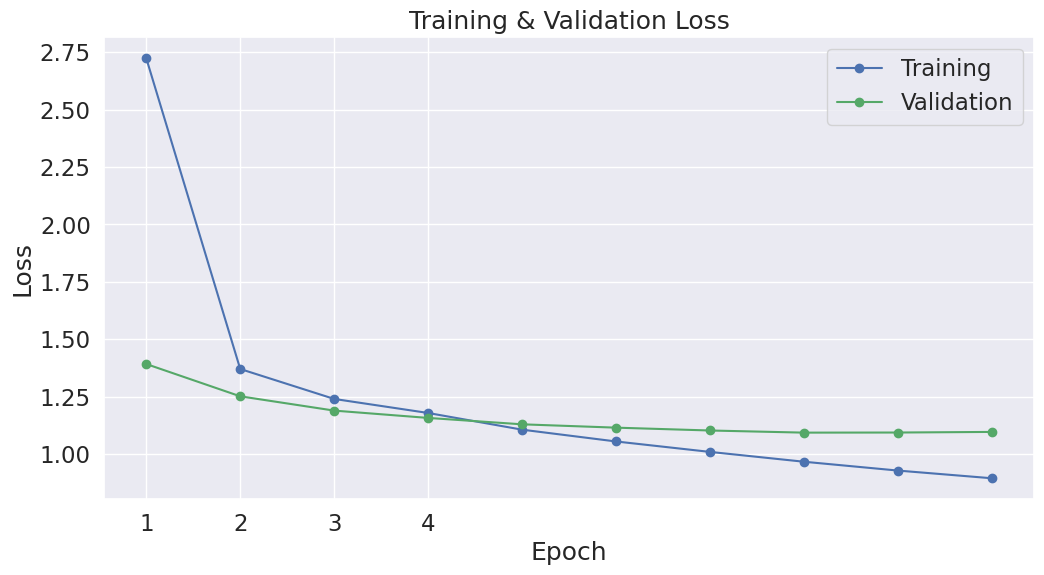

In [16]:
import matplotlib.pyplot as plt
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [17]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [18]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

tensor([[50257]], device='cuda:0')


In [19]:
sample_outputs = model.generate(
                                generated, 
                                pad_token_id=50258,
                                #bos_token_id=50257
                                #eos_token_id=50256
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 500,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

0: Portland Trail Blazers at Brooklyn Nets  January 4, 2022 at 07:30 PM The Portland Trail Blazers take on the Brooklyn Nets at Barclays Center on Monday night.  The Trail Blazers (19-24) have been surging in recent games, although their record may not be in line with their talent. Portland comes into Monday's contest having won five of their last six games, with its most recent success a 140-118 win over the Orlando Magic on Saturday night. Jerami Grant led the way with a 24-point, 10-rebound double-double that also included two assists and one steal. Anfernee Simons poured in 22 points, while Jusuf Nurkic generated an 18-point, 13-rebound double-double that also included two assists and two blocks. Drew Eubanks and Ben McLemore poured in 15 points apiece, with Eubanks adding five rebounds and five assists.  The Trail Blazers are likely to list Trendon Watford (ankle) as no better than questionable for Monday's game, while Justise Winslow (back) will remain out.  The Nets (16-24) have

In [21]:
input_ids_test = torch.tensor(tokenizer.encode("<|startoftext|> New York Knicks at Boston Celtics January 26, 2023 at 07:30 PM \
The Boston Celtics will host the New York Knicks at TD Garden on Thursday. \
The Celtics (35-14) are coming off a 98-95 loss against the Miami Heat on Tuesday. \
Jayson Tatum finished with 31 points, 14 rebounds and seven assists for the Celtics, \
while Derrick White ended with 23 points, six assists and three rebounds. \
Payton Pritchard ended with 10 points, seven rebounds and four assists, \
and Robert Williams III posted 11 points with eight rebounds. \
Grant Williams finished with 10 points and four boards as well. \
Boston has lost two games in a row against Eastern Conference opponents in the Orlando Magic and the \
Heat, but they still remain one of the best teams in the Eastern Conference. \
Boston has also gone 18-5 at home. Marcus Smart (ankle) and Danilo Gallinari (knee) are out for Thursday’s game. \
The Knicks (26-23) are coming off a 105-103 win over the Cleveland Cavaliers, \
and that win snapped the team’s three-game losing streak. \
Julius Randle paced the Knicks in that win with a 36-point, 13-rebound double-double that also included four assists. \
RJ Barrett supplied 16 points, four rebounds, one assist, one block and one steal. \
Jalen Brunson registered 14 points, four assists, two boards and one steal. \
Obi Toppin turned in 11 points and three rebounds. Quentin Grimes recorded 10 points, three assists, \
one rebound and one block. New York has gone 14-10 on the road this season. \
Evan Fournier (personal) has been listed as a game-time decision for Thursday, while Mitchell Robinson (thumb) is out.")).unsqueeze(0)
input_ids_test = input_ids_test.to(device)

# Example Output

Below is an example output from the model. Everything after "Mitchell Robinson is out" is generated by the model

Definitely some odd output happening "though Boston was much better, though not necessarily by much". But overall not too shabby. The individual point totals at the end are especially impressive, as they are pretty close to reality, as are the adjusted records after the game.

In [22]:
greedy_output = model.generate(input_ids_test, max_length=800, pad_token_id=50258, do_sample=True)
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))

 New York Knicks at Boston Celtics January 26, 2023 at 07:30 PM The Boston Celtics will host the New York Knicks at TD Garden on Thursday. The Celtics (35-14) are coming off a 98-95 loss against the Miami Heat on Tuesday. Jayson Tatum finished with 31 points, 14 rebounds and seven assists for the Celtics, while Derrick White ended with 23 points, six assists and three rebounds. Payton Pritchard ended with 10 points, seven rebounds and four assists, and Robert Williams III posted 11 points with eight rebounds. Grant Williams finished with 10 points and four boards as well. Boston has lost two games in a row against Eastern Conference opponents in the Orlando Magic and the Heat, but they still remain one of the best teams in the Eastern Conference. Boston has also gone 18-5 at home. Marcus Smart (ankle) and Danilo Gallinari (knee) are out for Thursday’s game. The Knicks (26-23) are coming off a 105-103 win over the Cleveland Cavaliers, and that win snapped the team’s three-game losing st

In [23]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/added_tokens.json')